In [13]:
import pandas as pd
import numpy as np

stl_path = "processed_data/stl_energy_production_with_weather.csv"
hp_path = "processed_data/hp_energy_production_with_weather.csv"

stl_df = pd.read_csv(stl_path)
hp_df = pd.read_csv(hp_path)

stl_df["Date"] = pd.to_datetime(stl_df["Date"])
hp_df["Date"] = pd.to_datetime(hp_df["Date"])

stl_df["Month"] = stl_df["Date"].dt.month
hp_df["Month"] = hp_df["Date"].dt.month

# Calculate Efficiency
stl_df["Efficiency"] = stl_df["Energy Production (kWh)"] / stl_df["Water_Flow_m3_s"]
hp_df["Efficiency"] = hp_df["Energy Production (kWh)"] / hp_df["Water_Flow_m3_s"]

stl_df["Efficiency"] = stl_df["Efficiency"].replace([np.inf, -np.inf], np.nan)
hp_df["Efficiency"] = hp_df["Efficiency"].replace([np.inf, -np.inf], np.nan)

stl_df.dropna(subset=["Efficiency"], inplace=True)
hp_df.dropna(subset=["Efficiency"], inplace=True)

# Feature Engineering
for df in [stl_df, hp_df]:    
    df["WaterFlow_Diff_1d"] = df["Water_Flow_m3_s"].diff(1)
    df["WaterFlow_Diff_7d"] = df["Water_Flow_m3_s"].diff(7)

    df["WaterFlow_3day_avg"] = df["Water_Flow_m3_s"].rolling(3).mean()
    df["WaterFlow_7day_avg"] = df["Water_Flow_m3_s"].rolling(7).mean()

    df["Temp_Deviation"] = df["avgtempC"] - df["avgtempC"].mean()
    df["WaterFlow_Humidity"] = df["Water_Flow_m3_s"] * df["humidity"]

    df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    df["Normalized_Efficiency"] = df["Efficiency"] / df["Efficiency"].mean()

    df["Prev_Day_Efficiency"] = df["Efficiency"].shift(1)
    df["Prev_Week_Efficiency"] = df["Efficiency"].shift(7)

stl_df.dropna(inplace=True)
hp_df.dropna(inplace=True)

print("STL Data Preview:")
print(stl_df.head())

print("HP Data Preview:")
print(hp_df.head())

print("STL Data Rows:", len(stl_df))
print("HP Data Rows:", len(hp_df))

stl_updated_path = "processed_data/stl_energy_production_with_engineered_features.csv"
hp_updated_path = "processed_data/hp_energy_production_with_engineered_features.csv"

stl_df.to_csv(stl_updated_path, index=False)
hp_df.to_csv(hp_updated_path, index=False)


STL Data Preview:
         Date   Station  Energy Production (kWh)  Water_Flow_m3_s  avgtempC  \
7  2022-01-04  Amberd 3              1455.962245     18022.752294        -2   
8  2022-01-04  Amberd 3              1455.962245     18147.491347        -2   
9  2022-01-05  Amberd 3               321.229222     18441.472148        -2   
10 2022-01-05  Amberd 3               321.229222     16296.513761        -2   
11 2022-01-05  Amberd 3               321.229222     16646.615149        -2   

    totalprecipMM  humidity  pressureMB  Month  Efficiency  ...  \
7             0.4        56        1020      1    0.080785  ...   
8             0.4        56        1020      1    0.080229  ...   
9             0.0        59        1025      1    0.017419  ...   
10            0.0        59        1025      1    0.019712  ...   
11            0.0        59        1025      1    0.019297  ...   

    WaterFlow_Diff_7d  WaterFlow_3day_avg  WaterFlow_7day_avg  Temp_Deviation  \
7         -433.861103  

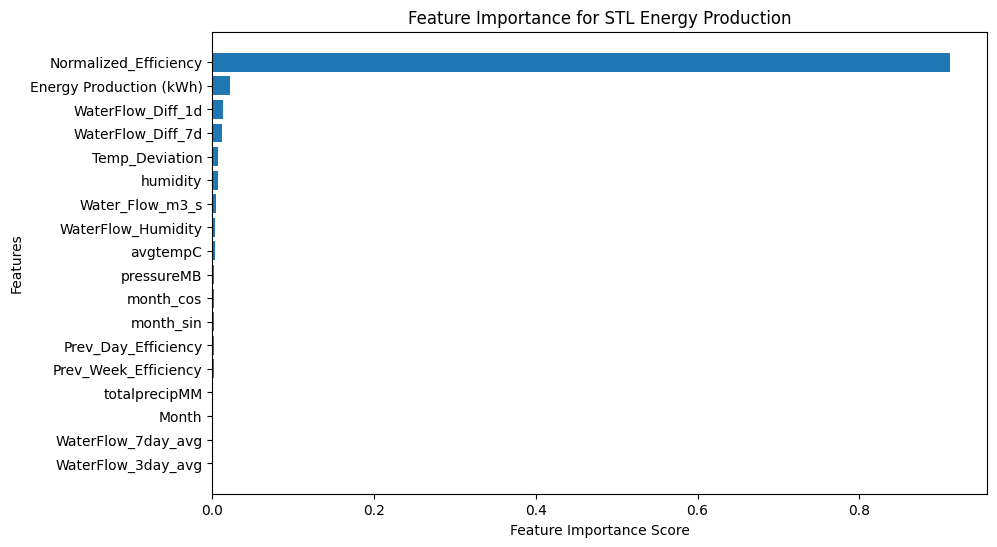

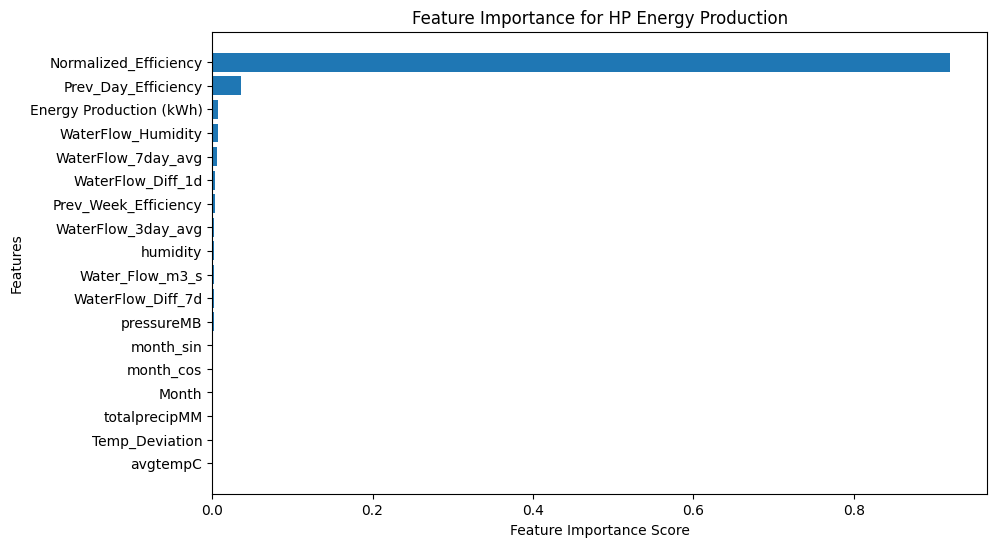

('Capstone/energy-production-analysis/visualizations/feature_importance/stl_feature_importance.png',
 'Capstone/energy-production-analysis/visualizations/feature_importance/hp_feature_importance.png')

In [14]:
feature_importance_folder = "Capstone/energy-production-analysis/visualizations/feature_importance"
os.makedirs(feature_importance_folder, exist_ok=True)

def save_feature_importance(df, title, filename):
    feature_cols = [col for col in df.columns if col not in ["Date", "Station", target_col]]
    df = df[feature_cols + [target_col]].dropna()

    X = df[feature_cols]
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = np.array(feature_cols)[sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, align="center")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(title)
    plt.gca().invert_yaxis()
    save_path = os.path.join(feature_importance_folder, filename)
    plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    plt.close()

    return save_path

stl_plot_path = save_feature_importance(stl_df, "Feature Importance for STL Energy Production", "stl_feature_importance.png")
hp_plot_path = save_feature_importance(hp_df, "Feature Importance for HP Energy Production", "hp_feature_importance.png")

stl_plot_path, hp_plot_path

### Feature Verification: Why These Matter

**1. Normalized_Efficiency**  
Standardizes the efficiency to make values more comparable across time. Highlights how well the plant performs.

**2. Prev_Day_Efficiency / Prev_Week_Efficiency**  
Lag features are essential in time-series forecasting. They help capture performance trends.

**3. WaterFlow_Humidity**  
This interaction might reflect climate/environment impact on the plant. Humid air can indirectly affect evaporation, pressure, etc.

**4. Temp_Deviation**  
Extreme deviations can reflect anomalies or system inefficiencies.

**5. Rolling Averages**  
Help smooth out temporary fluctuations in flow, revealing actual trends.
